In [1]:
%matplotlib notebook
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from astropy.table import Table
from astroquery.irsa_dust import IrsaDust
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import quad
from scipy.optimize import curve_fit
import sncosmo
import sys
import tables
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [57]:
# iPTF16abc data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict(), "LCO-1m/Sinistro": dict(), "Swift/UVOT": dict(), "SPM-1.5m/RATIR": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["B", "V", "g", "r", "i"]:
    lc["LCO-1m/Sinistro"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["UVW2", "UVM2", "UVW1", "U", "B", "V"]:
    lc["Swift/UVOT"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'Swift') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

for filter_name in ["r", "i", "Z", "Y", "J", "H"]:
    lc["SPM-1.5m/RATIR"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'SPM-1.5m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

        

spec_epochs = [t.attrs.OBS_DATE for t in h5file.root.spectroscopy]
    
        
h5file.close()

In [3]:
# data from Piro & Morozova models
Piro_col_names = ("Time", "Teff", 
                  "PTF_R", 
                  "u", "g", "r", "i", "z", 
                  "U", "B", "V", "R", "I")

In [41]:
# properties iPTF16abc
z = 0.0234
mu = 34.89
mu_unc = 0.10
t = 0.15  # days. First detection of iPTF16abc
mag = 21.4  # mag. First mag of iPTF16abc
local_EBV = 0.05
galactic_EBV = 0.0279

A_g = 0.33 # assuming E(B-V)_SFD = 0.0779/0.78
A_r = 0.23
A_B = 0.36
A_V = 0.27
A_U = 0.43

# properties for making plots
T_MAX = 57499.537694
T_0 = 57481.21
T_exp = 57481.68
colors = {"UVW2": "black",
          "UVM2": "Purple",
          "UVW1": "Cyan",
          "U": "DarkBlue",
          "B": "Blue",
          "V": "SkyBlue", 
          "g": "Green",
          "R": "Red", 
          "r": "Red",
          "i": "Yellow"}
markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s"}
offsets = {"UVW2": 6,
           "UVM2": 4,
           "UVW1": 4,
           "U": 3,
           "B": 2,
           "V": 1,
           "g": 0,
           "R": -1,
           "r": -1,
           "i": -3}

AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#061283", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#4897D8", # electric blue
             'B-V': "#89DA59", # spring green
             'g-r': "#F9DC24", # sunset #F77604", # caviar
             'r-i': "#FF0038"  # ripe tomato
            }


AAMoffsets = {'UVW2-V': 1, # midnight blue
              'UVW1-V': 1, # fig or #50312F eggplant
              'U-V': 2, # blueberry
              'B-V': 1, # yellow pepper
              'g-r': 0, # carrot
              'r-i': -1  # tomato
             }

g_filt_dict = {"P48/CFH12K": "g", "P60/SEDm": "g'", "LCO-1m/Sinistro": "g'"}

In [5]:
def lc_color(t_blue, m_blue, m_blue_unc, t_red, m_red, m_red_unc, delta_t_merge = 1/24):
    """Return the (merged) color curve for two filters 
    
    Parameters
    ----------
    t_blue : array-like 
        Time array for blue filter measurements
        
    m_blue : array-like, shape = t_blue.shape
        mag array for the blue filter measurements
        
    m_blue_unc : array-like, shape = t_blue.shape
        mag uncertainties array for the blue filter measurements
    
    t_red : array-like
        Time array for red filter measurements
        
    m_red : array-like, shape = t_red.shape
        mag array for the red filter measurements
        
    m_red_unc : array-like, shape = t_red.shape
        mag uncertainties array for the red filter measurements

    delta_t_merge : float, optional (default = 1/24)
    
    Returns
    -------
    t_color : array-like
        mean time of joined red and blue filter obs 
    
    m_color : array-like
        mag of joined red and blue filter obs
    
    m_color_unc : array-like
        mag uncertainty for joined red and blue filter obs
    """

    if len(t_blue) != len(m_blue) or len(t_blue) != len(m_blue_unc):
        raise ValueError('Length of t_blue, m_blue, and m_blue_unc do not match')

    if len(t_red) != len(m_red) or len(t_red) != len(m_red_unc):
        raise ValueError('Length of t_red, m_red, and m_red_unc do not match')

    t_red = np.ma.array(t_red, mask = np.zeros(t_red.shape))
    m_red = np.ma.array(m_red, mask = np.zeros(m_red.shape))
    m_red_unc = np.ma.array(m_red_unc, mask = np.zeros(m_red_unc.shape))
    
    t_color = np.empty(0)
    m_color = np.empty(0)
    m_color_unc = np.empty(0)
    delta_t_merge = 1/24.
    
    for tb, mb, mbu in zip(t_blue, m_blue, m_blue_unc):
        if np.min(np.abs(t_red - tb)) < delta_t_merge:
            match_idx = np.argmin(np.abs(t_red - tb))
            t_color = np.append(t_color, (tb + t_red[match_idx]) / 2)
            m_color = np.append(m_color, mb - m_red[match_idx] )

            m_color_unc = np.append(m_color_unc, 
                                    np.hypot(mbu, m_red_unc[match_idx]))
            t_red.mask[match_idx] = True
    
    return t_color, m_color, m_color_unc
        
        

<IPython.core.display.Javascript object>


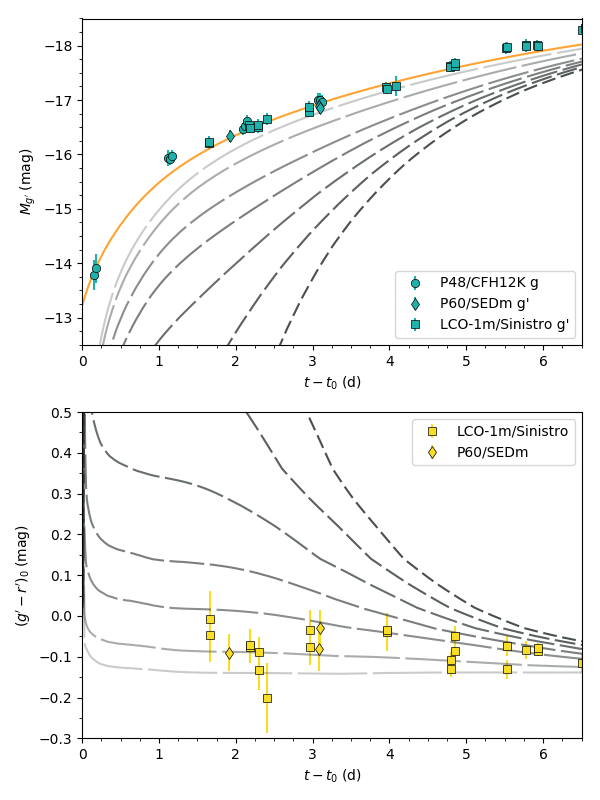

In [46]:
# abs - mag plot

fig, (ax1, ax2) = plt.subplots(2,1, figsize = (6,8))

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    ax1.errorbar( (lc[tel_inst]['g']['time'] - T_0)/(1+z), 
              lc[tel_inst]['g']['mag'] - mu - A_g, 
              np.hypot(lc[tel_inst]['g']['mag_err'], 0.1), 
              c = AAMcolors['g'], fmt = markers[tel_inst.split("/")[0]], 
              mec = 'k', mew = 0.5, ms = 6,
              label="{:s} {:s}".format(tel_inst, g_filt_dict[tel_inst]))
leg = ax1.legend(loc = 4, fancybox=True) # set legend here to exclude line labels

base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    ax1.plot(dat["Time"]/86400, dat["g"], 
             c = AAMcolors['Ni_models'], 
             alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])

ax1.plot(dat["Time"]/86400 - 0.35, dat["g"], color = "DarkOrange", alpha = 0.8)

ax1.set_ylim(-12.5,-18.5)
ax1.set_xlim(0, 6.5)
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax1.xaxis.set_minor_locator(MultipleLocator(0.25))

ax1.set_ylabel(r"$M_{g'} \; (\mathrm{mag})$")
ax1.set_xlabel(r"$t - t_0 \; (\mathrm{d})$")

for tel_inst in ['LCO-1m/Sinistro', 'P60/SEDm']:
    t_col, m_col, m_col_unc = lc_color(lc[tel_inst]['g']['time'], 
                                         lc[tel_inst]['g']['mag'], 
                                         lc[tel_inst]['g']['mag_err'],
                                         lc[tel_inst]['r']['time'], 
                                         lc[tel_inst]['r']['mag'], 
                                         lc[tel_inst]['r']['mag_err'])

    ax2.errorbar((t_col - T_0)/(1+z), m_col - (A_g - A_r), m_col_unc, 
                 c = AAMcolors['g-r'], fmt = markers[tel_inst.split("/")[0]],
                 mec = 'k', mew = 0.5, ms = 6, 
                 label="{:s}".format(tel_inst))
leg = ax2.legend()     
    
base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    ax2.plot(dat["Time"]/86400, dat["g"] - dat["r"], 
             c = AAMcolors['Ni_models'], 
             alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])

ax2.set_ylim(-0.3,0.5)
ax2.set_xlim(0, 6.5)
ax2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax2.xaxis.set_minor_locator(MultipleLocator(0.25))

ax2.set_ylabel(r"$(g' - r')_0 \; (\mathrm{mag})$")
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$")
fig.tight_layout()
# plt.savefig('iPTF16abc_Ni_lc.pdf')

<IPython.core.display.Javascript object>


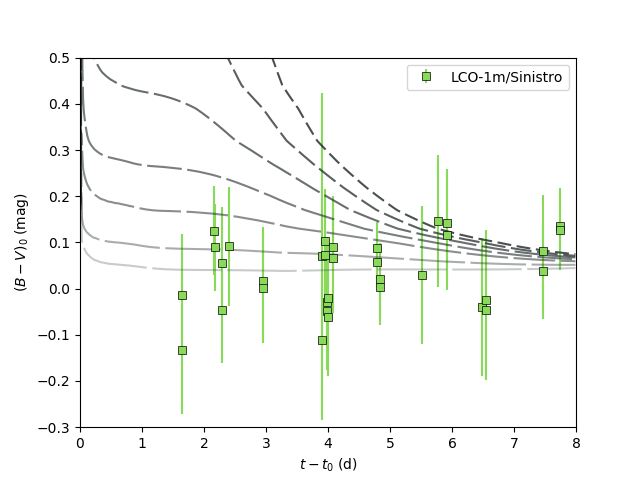

In [44]:
# colors plot
fig, ax2 = plt.subplots()
    
for tel_inst in ['LCO-1m/Sinistro']:
    t_col, m_col, m_col_unc = lc_color(lc[tel_inst]['B']['time'], 
                                         lc[tel_inst]['B']['mag'], 
                                         lc[tel_inst]['B']['mag_err'],
                                         lc[tel_inst]['V']['time'], 
                                         lc[tel_inst]['V']['mag'], 
                                         lc[tel_inst]['V']['mag_err'])

    ax2.errorbar((t_col - T_0)/(1+z), m_col - (A_B - A_V), m_col_unc,
                 c = AAMcolors['B-V'], fmt = markers[tel_inst.split("/")[0]],
                 mec = 'k', mew = 0.5, ms = 6, 
                 label="{:s}".format(tel_inst))
leg = ax2.legend()     
    
base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    ax2.plot(dat["Time"]/86400, dat["B"] - dat["V"], 
             c = AAMcolors['Ni_models'], 
             alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])

ax2.set_ylim(-0.3,0.5)
ax2.set_xlim(0, 8)

ax2.set_ylabel(r"$(B - V)_0 \; (\mathrm{mag})$")
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$")

<IPython.core.display.Javascript object>


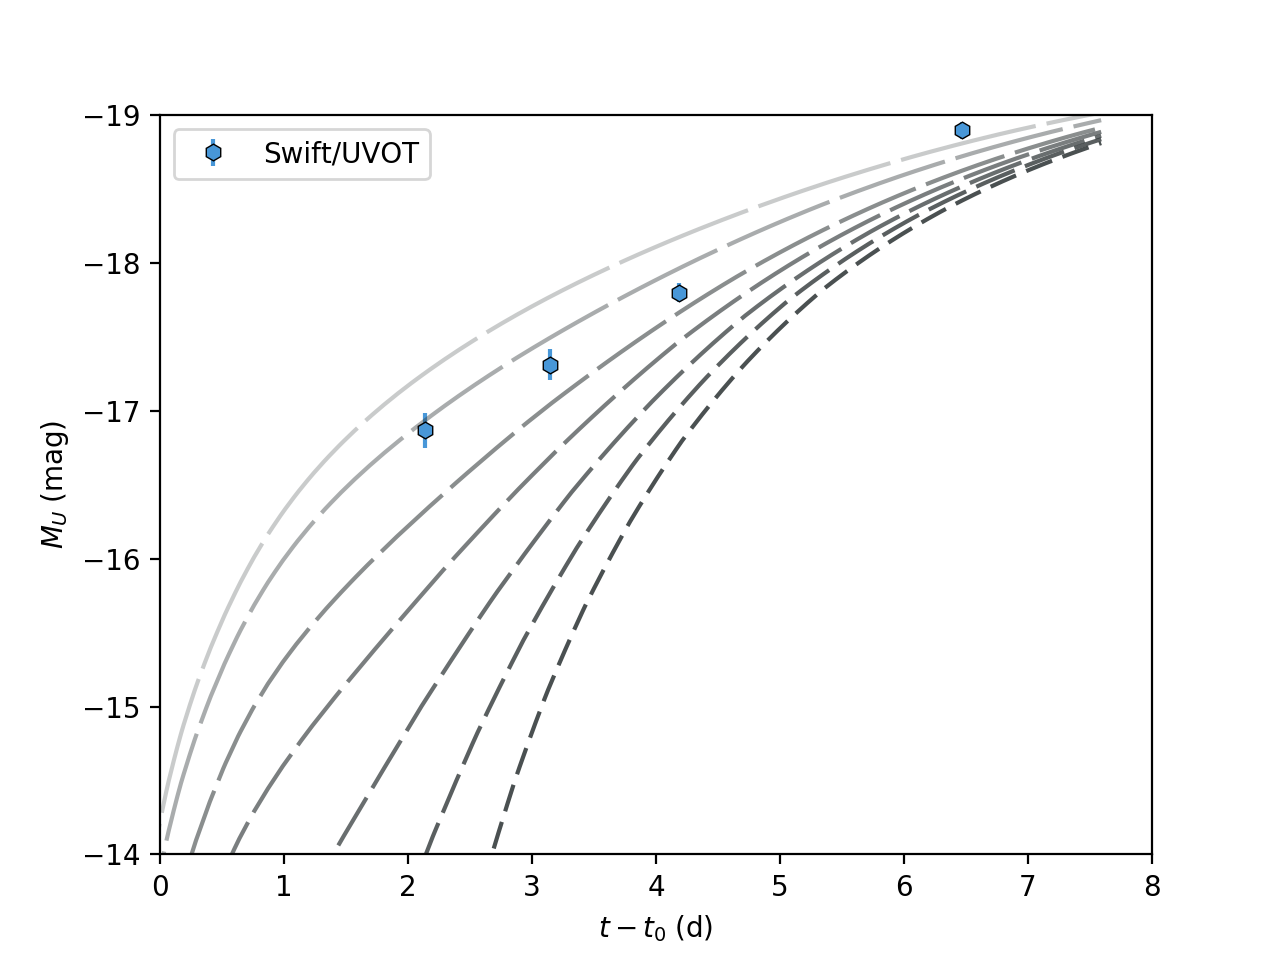

In [52]:
# colors plot
fig, ax2 = plt.subplots()
    
tel_inst = 'Swift/UVOT'
ax2.errorbar((lc[tel_inst]['U']['time'] - T_0)/(1+z), lc[tel_inst]['U']['mag'] - mu - A_U -0.79, lc[tel_inst]['U']['mag_err'], 
                 c = "#4897D8", fmt = markers[tel_inst.split("/")[0]],
                 mec = 'k', mew = 0.5, ms = 6, 
                 label="{:s}".format(tel_inst))
leg = ax2.legend()     
    
base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    ax2.plot(dat["Time"]/86400-0.4, dat["U"], 
             c = AAMcolors['Ni_models'], 
             alpha = 1 - mixing*3,
#              label = r'${:s} \; M_\odot$'.format(str(mixing)),
             dashes = [mixing*100, 2])

ax2.set_ylim(-14,-19)
ax2.set_xlim(0, 8)

ax2.set_ylabel(r"$M_U \; (\mathrm{mag})$")
ax2.set_xlabel(r"$t - t_0 \; (\mathrm{d})$")

In [40]:
min(lc["Swift/UVOT"]["U"]["time"])

57483.398

<IPython.core.display.Javascript object>


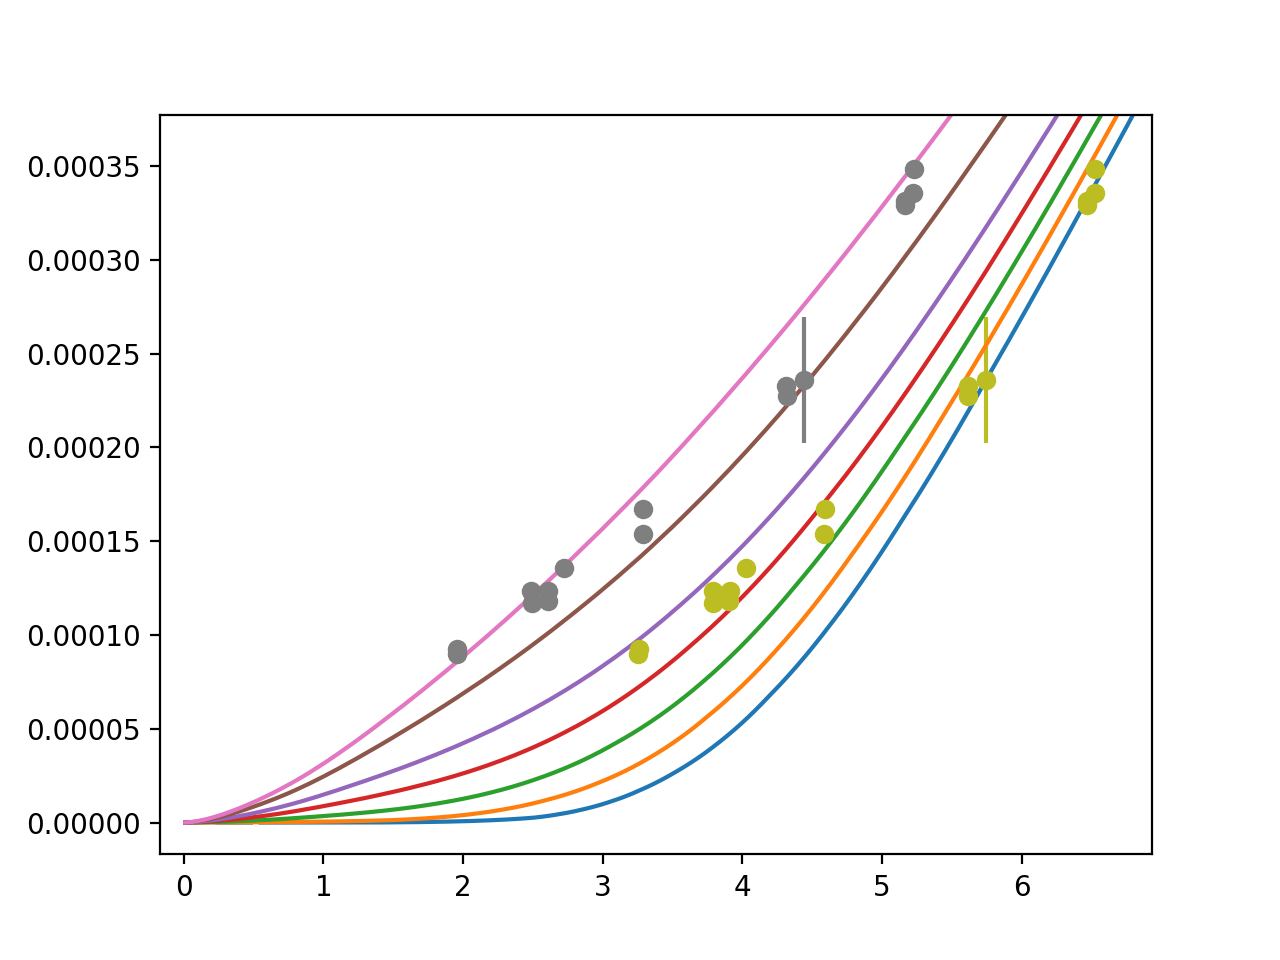

<Container object of 3 artists>

In [94]:
# convert M_g to flux
M_g = dat["g"]
m_g = M_g + mu + A_g
flux = 10**(-0.4*m_g)*3631

base_file = "Piro_models/ia_mixing/magnitudes_{:s}.dat"
for mixing in [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25]:
    dat = Table.read(base_file.format(str(mixing)), format = "ascii", names = Piro_col_names)
    M_g = dat["g"]
    m_g = M_g + mu + A_g
    flux = np.power(10,(-0.4*m_g))*3631
    plt.plot(dat["Time"]/86400, flux)

plt.errorbar(lc['LCOGT-1m_g']['time'] - T_0, lc['LCOGT-1m_g']['flux'], lc['LCOGT-1m_g']['flux_err'], fmt = 'o')



<IPython.core.display.Javascript object>


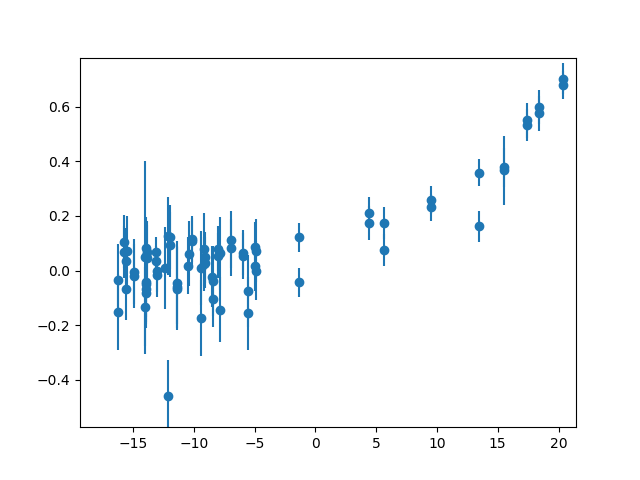

<Container object of 3 artists>

In [29]:
plt.errorbar((t_col - T_MAX)/(1+z), m_col, m_col_unc, fmt = "o")

In [51]:
import pandas as pd
t = np.empty(0)
abs_mag = np.empty(0)
abs_mag_unc = np.empty(0)
tel_inst_arr = np.empty(0, dtype = "S15")

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    t = np.append(t, (lc[tel_inst]['g']['time'] - T_0)/(1+z))
    abs_mag = np.append(abs_mag, lc[tel_inst]['g']['mag'] - mu - A_g)
    abs_mag_unc = np.append(abs_mag_unc, np.hypot(lc[tel_inst]['g']['mag_err'], mu_unc))
    tel_inst_arr = np.append(tel_inst_arr, np.array([tel_inst]*len(lc[tel_inst]['g']['mag']), dtype = "S15"))
abs_mag_g = pd.DataFrame(t, columns = ["time"])
abs_mag_g["M"] = abs_mag
abs_mag_g["M_unc"] = abs_mag_unc
abs_mag_g["telescope"] = tel_inst_arr
abs_mag_g.to_csv("/Users/adamamiller/Desktop/16abc_M_g.csv", index = False)

# g band obs
t = np.empty(0)
g_mag = np.empty(0)
g_mag_unc = np.empty(0)
tel_inst_arr = np.empty(0, dtype = "U15")

for tel_inst in ['P48/CFH12K', 'P60/SEDm', 'LCO-1m/Sinistro']:
    t = np.append(t, (lc[tel_inst]['g']['time'] - T_0)/(1+z))
    g_mag = np.append(g_mag, lc[tel_inst]['g']['mag'])
    g_mag_unc = np.append(g_mag_unc, lc[tel_inst]['g']['mag_err'])
    tel_inst_arr = np.append(tel_inst_arr, np.array([tel_inst]*len(lc[tel_inst]['g']['mag']), dtype = "U15"))
mag_g = pd.DataFrame(t, columns = ["time"])
mag_g["M"] = g_mag
mag_g["M_unc"] = g_mag_unc
mag_g["telescope"] = tel_inst_arr
mag_g.to_csv("/Users/adamamiller/Desktop/16abc_g.csv", index = False)

# r band obs
for tel_inst in ['LCO-1m/Sinistro']:
    t = (lc[tel_inst]['r']['time'] - T_0)/(1+z)
    r_mag = lc[tel_inst]['r']['mag']
    r_mag_unc = lc[tel_inst]['r']['mag_err']
mag_r = pd.DataFrame(t, columns = ["time"])
mag_r["M"] = r_mag
mag_r["M_unc"] = r_mag_unc
mag_r.to_csv("/Users/adamamiller/Desktop/16abc_r.csv", index = False)


# UVW1 band obs
for tel_inst in ['Swift/UVOT']:
    t = (lc[tel_inst]['UVW1']['time'] - T_0)/(1+z)
    uvw1_mag = lc[tel_inst]['UVW1']['mag']
    uvw1_mag_unc = lc[tel_inst]['UVW1']['mag_err']
mag_uvw1 = pd.DataFrame(t, columns = ["time"])
mag_uvw1["m"] = uvw1_mag
mag_uvw1["m_unc"] = uvw1_mag_unc
mag_uvw1.to_csv("/Users/adamamiller/Desktop/16abc_uvw1.csv", index = False)

# UVW2 band obs
for tel_inst in ['Swift/UVOT']:
    t = (lc[tel_inst]['UVW2']['time'] - T_0)/(1+z)
    uvw2_mag = lc[tel_inst]['UVW2']['mag']
    uvw2_mag_unc = lc[tel_inst]['UVW2']['mag_err']
mag_uvw2 = pd.DataFrame(t, columns = ["time"])
mag_uvw2["m"] = uvw2_mag
mag_uvw2["m_unc"] = uvw2_mag_unc
mag_uvw2.to_csv("/Users/adamamiller/Desktop/16abc_uvw2.csv", index = False)

# UVM2 band obs
for tel_inst in ['Swift/UVOT']:
    t = (lc[tel_inst]['UVM2']['time'] - T_0)/(1+z)
    uvm2_mag = lc[tel_inst]['UVM2']['mag']
    uvm2_mag_unc = lc[tel_inst]['UVM2']['mag_err']
mag_uvm2 = pd.DataFrame(t, columns = ["time"])
mag_uvm2["m"] = uvm2_mag
mag_uvm2["m_unc"] = uvm2_mag_unc
mag_uvm2.to_csv("/Users/adamamiller/Desktop/16abc_uvm2.csv", index = False)

# U band obs
for tel_inst in ['Swift/UVOT']:
    t = (lc[tel_inst]['U']['time'] - T_0)/(1+z)
    u_mag = lc[tel_inst]['U']['mag']
    u_mag_unc = lc[tel_inst]['U']['mag_err']
mag_u = pd.DataFrame(t, columns = ["time"])
mag_u["m"] = u_mag
mag_u["m_unc"] = u_mag_unc
mag_u.to_csv("/Users/adamamiller/Desktop/16abc_U.csv", index = False)

# B-V color
for tel_inst in ['LCO-1m/Sinistro']:
    t_col, m_col, m_col_unc = lc_color(lc[tel_inst]['B']['time'], 
                                         lc[tel_inst]['B']['mag'], 
                                         lc[tel_inst]['B']['mag_err'],
                                         lc[tel_inst]['V']['time'], 
                                         lc[tel_inst]['V']['mag'], 
                                         lc[tel_inst]['V']['mag_err'])

BminusV = pd.DataFrame((t_col - T_0)/(1+z), columns = ["time"])
BminusV["B-V"] = m_col - (A_B - A_V)
BminusV["B-Vunc"] = m_col_unc
BminusV.to_csv("/Users/adamamiller/Desktop/16abc_B-V.csv", index = False)

# g-r color
for tel_inst in ['LCO-1m/Sinistro']:
    t_col, m_col, m_col_unc = lc_color(lc[tel_inst]['g']['time'], 
                                         lc[tel_inst]['g']['mag'], 
                                         lc[tel_inst]['g']['mag_err'],
                                         lc[tel_inst]['r']['time'], 
                                         lc[tel_inst]['r']['mag'], 
                                         lc[tel_inst]['r']['mag_err'])

gminusr = pd.DataFrame((t_col - T_0)/(1+z), columns = ["time"])
gminusr["g-r"] = m_col - (A_g - A_r)
gminusr["g-runc"] = m_col_unc
gminusr.to_csv("/Users/adamamiller/Desktop/16abc_g-r.csv", index = False)

# Swift photometry
